# t-Distributed Stochastic Neighbor Embedding (t-SNE)

In this exercise, you will implement elements of the t-SNE algorithm described in the paper by Laurens van der Maaten (available on ISIS), and analyze its behavior. As a reminder, here are the main steps of the t-SNE procedure described in the paper:

* compute pairwise affinities $p_{j|i}$ with perplexity perp using $p_{j|i} = \frac{\exp(-||x_i - x_j||^2/2\sigma^2)}{\sum_{k \neq i} \exp(-||x_i - x_k||^2/2\sigma^2)}$

* Optimize the perplexity for each element i to give the target perplexity (provided in `utils.py`)

* Symmetrize the affinity matrix using $p_{ij} = \frac{p_{j|i}+p_{i|j}}{2N}$

* Consider an initial embedding $Y^{0}$


* Repeat for multiple iterations:

   * Compute the affinities in the embedded space $q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq i}(1 + ||y_i - y_k||^2)^{-1}}$
   
   * Compute the gradient $\frac{\partial C}{\partial Y}$ using $\frac{\partial C}{\partial Y_i} = 4 \sum_{j} (p_{ij}-q_{ij})(y_i-y_j)(1 + ||y_i - y_j||^2)^{-1} $
   
   * Update the embedding using the update rule $Y^{t} = Y^{t-1} + \eta \frac{\partial C}{\partial Y} + \alpha (t)( Y^{t-1}-Y^{t-2}) $, where $Y^{t}$ is the value of $Y$ at time $t$, where $Y^{t}=(0,0,...,0)$ for $t<0$ and where $\alpha (t) = 0.5$ at the beginning of the training procedure and $0.8$ towards the end.
   

* Return the final embedding $Y^{T}$ where $T$ is the number of iterations

## Implementing t-SNE (30P)

You are asked to implement several functions that are used by the t-SNE algorithm. Their specification is given below. In their current form, they simply call functions of the module `solutions`, which is not provided. Replace these calls by your own implementation of the functions. Remark that most of the time, we work with log-probabilities. It is more convenient and numerically stable when the probabilities need to be defined or normalized. (See for example the function `scipy.misc.logsumexp` for that purpose.)

In [1]:
import numpy as np
import scipy.misc

In [3]:
X = np.random.rand(100,2)

In [4]:
from scipy.spatial.distance import pdist, squareform
def student(Y):
    # Calculate the join log-probabilities log(q_ij) defined above
    #
    # input:  Y    - An Nx2 array containing the embedding
    # return: logQ - An NxN array containing log(q_ij)
    
#     D = distmat2(Y)
#     D2 = 1./(1. + D)
#     D2_sum_without_i = D.sum(0) - D2
#     Q = D2 / ( D2_sum_without_i )
#     logQ = np.log(Q)
#     return logQ
    N = Y.shape[0]
#     dist = squareform(pdist(Y))
    
    Q = 1/(1+scipy.spatial.distance.cdist(Y,Y,'sqeuclidean'))
    Q /= np.sum(Q)-N
    
    return np.log(Q)

def objective(logP,logQ):
    # Calculate the objective of t-SNE to minimize. The objective is the
    # KL divergence C = KL(P||Q)
    # 
    # inputs: logP - An NxN array containing log(p_ij)
    #         logQ - An NxN array containing log(q_ij)
    # return: C    - The value of the objective

    C = ( np.exp(logP)*(logP-logQ) ).sum()
    return C

def gradient(logP,Y):
    # Computes the gradient as described above.
    #
    #inputs: logP  - An NxN array containing log(p_ij)
    #        Y     - An Nx2 array containing the embedding
    #return: gradY - the gradient of the objective with respect to Y
    
#     logQ = student(Y)
#     Q = np.exp(logQ)
#     P = np.exp(logP)
    
#     gradY2 = np.zeros_like(Y)
#     dist = squareform(pdist(Y))

#     for i in xrange(Y.shape[0]):
#         for j in xrange(Y.shape[0]):
#             gradY2[i] += 4*(P[i,j]-Q[i,j])*(Y[i]-Y[j])*(1/(1+dist[i,j]**2))  
#     print(gradY2.shape)

    logQ = student(Y)
    dist = squareform(pdist(Y))**2
    D = 1./(1.+dist)
    Yij = np.array([y-Y for y in Y])
    PQ = (np.exp(logP)-np.exp(logQ))
#     print(PQ.shape, "PQ")
#     print(D.shape, "D")
#     print(Yij.shape, "Yij")
#     print(Y.shape, "Y")
    gradY = 4. * np.array([(PQ)*(Yij[:,:,i])*(D) for i in range(len(Y[0]))]).sum(1).T
#     print(gradY.shape)
#     print(gradY2+gradY)
    return -gradY
gradient(student(np.random.randn(5,2)),student(np.random.randn(5,2)))

array([[-0.05644782,  0.0209661 ,  0.00218123,  0.01010523,  0.00676365],
       [ 0.0305837 ,  0.0201705 ,  0.00750039,  0.0251588 , -0.0178452 ],
       [ 0.02868264,  0.13078198, -0.02947244,  0.12977109,  0.01455721],
       [-0.03100581, -0.12481562,  0.08746473, -0.09436387, -0.07443671],
       [ 0.02818728, -0.04710297, -0.0676739 , -0.07067125,  0.07096104]])

The code below implements t-SNE algorithm. It takes as input some unsupervised dataset `X` (a `Nxd` array), and compute a two-dimensional embedding starting from an initial embedding `Y0` (a `Nx2` array). Various training parameters can be specified as optional parameters. The t-SNE algorithm makes use of the functions that are defined above.

In [5]:
import utils
import numpy as np

def TSNE(X,Y0,perplexity=25,learningrate=1.0,nbiterations=250,steps=False,silent=False):

    N,d = X.shape
    
    if (not silent):
        print('get affinity matrix')
    
    # get the affinity matrix in the original space
    logP = utils.getaffinity(X,perplexity)
    
    # create initial embedding and update direction
    Y  = Y0*1
    dY = Y*0
    
    if not silent:
        print('run t-SNE')
    
    for t in range(nbiterations):

        # compute the pairwise affinities in the embedding space
        logQ = student(Y)
        
        # monitor objective
        if t %50 == 0:
            if not silent:
                print('%3d %.3f'%(t,objective(logP,logQ)))
            if steps:
                plt.scatter(*Y.T,c=color)
                plt.title('t=' + str(t))
                plt.show()
        
        # update
        dY = (0.5 if t < 100 else 0.8)*dY + learningrate*gradient(logP,Y)
        Y = Y - dY

    return Y

We test the T-SNE algorithm on the handwritten digits dataset, and compare the found embedding with simple PCA analysis.

In [6]:
import utils
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline

Loading digits


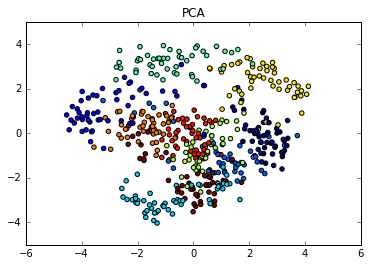

get affinity matrix
 25 8.491 10.000
 50 10.445 10.000
 75 10.133 10.000
100 9.314 10.000
run t-SNE
  0 4.092


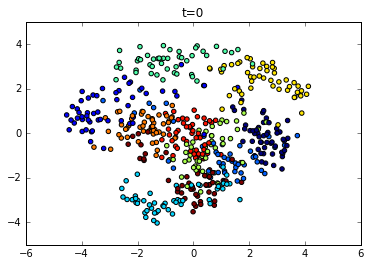

 50 3.797


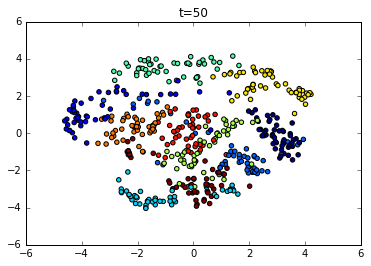

100 3.598


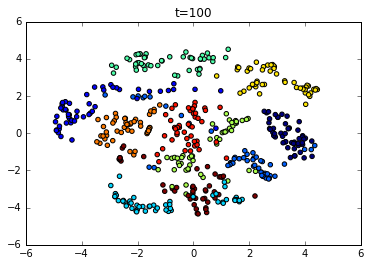

150 3.281


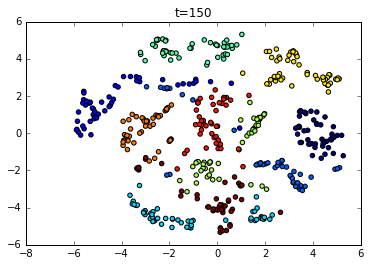

200 3.086


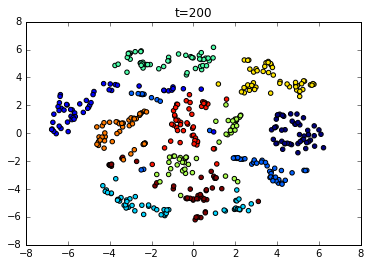

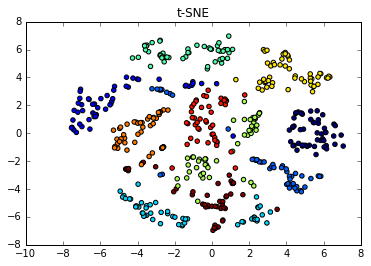

In [142]:
# read input dataset
X,color=utils.get_data(mode=1)

# run PCA
U,W,_ = np.linalg.svd(X,full_matrices=False)
Y0 = U[:,:2]*W[:2]
plt.scatter(*Y0.T,c=color); plt.title('PCA')
plt.show()

# run TSNE starting with PCA embedding as an initial solution
Y = TSNE(X,Y0,perplexity=10,learningrate=5.0,steps=True)
plt.scatter(*Y.T,c=color)
plt.title('t-SNE')
plt.show()

## Experimenting With t-SNE (20P)

The file `utils.py` contains a method `get_data(type)` that provides three datasets:

* A collection of digits (less complex than MNIST)
* Boston housing dataset
* Iris dataset

Using your implementation of t-SNE, and running it on the various dataset and with specific training parameters, answer the questions below. Along with your textual answers, include relevant results from running t-SNE in the code cell beneath each question where you should run code with certain parameters (perplexity, learning rate, choice of dataset) relevant to your answer.

How does perplexity and learning rate impact performance? What kind of extreme behaviour these parameters can cause?

**Extremely low values of perplexity will make points in the embedding appear evenly distributed. High values make the points in the embedding appear arbitrarily clumped together. The perplexity-value seems to be important for the quality of the logP-estimate.**

**Low learning rates will require many iterations for a meaningful result. High learning rates seem to cause the distance between clusters to decrease.**

Loading digits


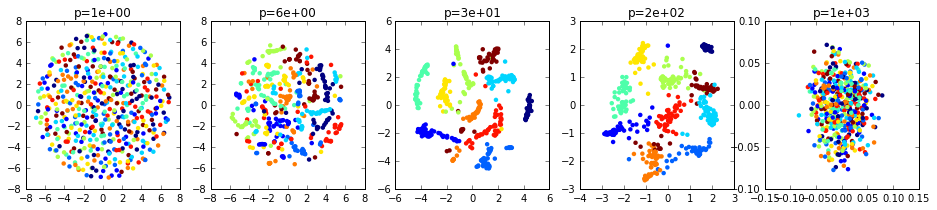

In [23]:
# importance of perplexity with random initialization
X,color = utils.get_data(1)
Y0 = np.random.multivariate_normal([0.0,0.0], 10e-4*np.eye(2), len(X))

n = 5
plt.figure(figsize=(16,int(16/n)))
for i,p in enumerate(np.logspace(0,3,n)):
#     print("\np = %.e" % (p))
    Y = TSNE(X,Y0,perplexity=p,learningrate=5.0,silent=True)
    plt.subplot(1,n,i+1)
    plt.scatter(*Y.T,c=color,linewidth=0)
    plt.title('p=%.e' %(p))
plt.show()

Loading iris


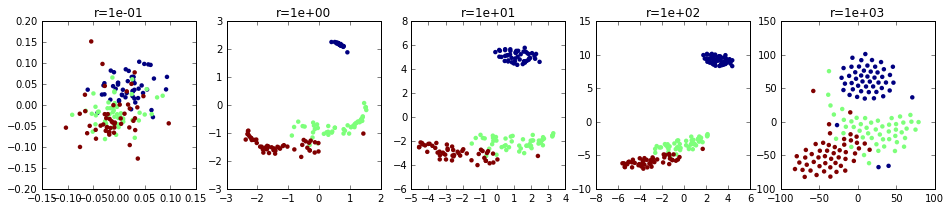

In [8]:
# importance of learning rate with random initialization
X,color = utils.get_data(3)
Y0 = np.random.multivariate_normal([0.0,0.0], 10e-4*np.eye(2), len(X))

n = 5
plt.figure(figsize=(16,int(16/n)))
for i,r in enumerate(np.logspace(-1,3,n)):
#     print("\nr = %.e" % (r))
    Y = TSNE(X,Y0,perplexity=50,learningrate=r,silent=True)
    plt.subplot(1,n,i+1)
    plt.scatter(*Y.T,c=color,linewidth=0)
    plt.title('r=%.e' %(r))
plt.show()

What kind of insight into the dataset you're dealing with can tSNE provide? Show one such example.

**For classification datasets you might be able to infer a lower bound on the number of classes by looking at the embedding (see dataset 3 example directly above). You also see the relative distances between clusters.**

How does the embedding evolve during the optimization procedure (i.e. how are the clusters being formed progressively)?

**The algorithm tries to match the neighborhood distributions of points in the original space to the ones in the embedded space by moving the embedded points. It does so by a gradient descent with impulse term.**

Loading digits


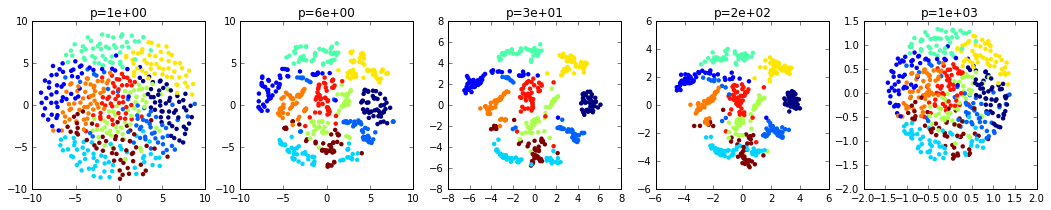

In [25]:
# importance of perplexity with PCA init
# => extreme values will cause uniformly distributed points, but similar points are near each other
X,color = utils.get_data(1)
U,W,_ = np.linalg.svd(X,full_matrices=False)
Y0 = U[:,:2]*W[:2]

n = 5
plt.figure(figsize=(18,int(18/n)))
for i,p in enumerate(np.logspace(0,3,n)):
#     print("\np = %.e" % (p))
    Y = TSNE(X,Y0,perplexity=p,learningrate=5.0,silent=True)
    plt.subplot(1,n,i+1)
    plt.scatter(*Y.T,c=color,linewidth=0)
    plt.title('p=%.e' %(p))
plt.show()

Loading digits


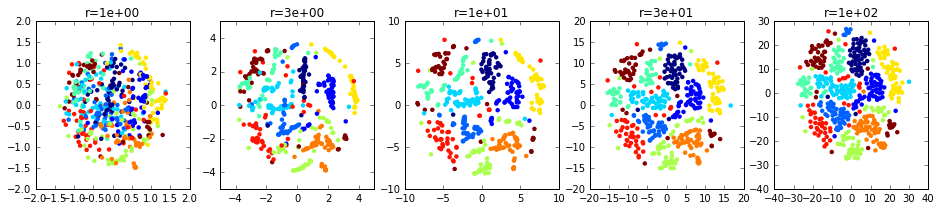

In [26]:
# importance of learning rate with random initialization
X,color = utils.get_data(1)
Y0 = np.random.multivariate_normal([0.0,0.0], 10e-4*np.eye(2), len(X))

n = 5
plt.figure(figsize=(16,int(16/n)))
for i,r in enumerate(np.logspace(0,2,n)):
#     print("\nr = %.e" % (r))
    Y = TSNE(X,Y0,perplexity=10,learningrate=r,silent=True)
    plt.subplot(1,n,i+1)
    plt.scatter(*Y.T,c=color,linewidth=0)
    plt.title('r=%.e' %(r))
plt.show()

Loading boston housing


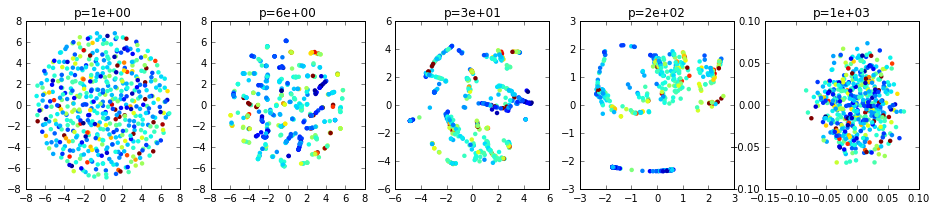

In [27]:
X,color = utils.get_data(2)
Y0 = np.random.multivariate_normal([0.0,0.0], 10e-4*np.eye(2), len(X))

n = 5
plt.figure(figsize=(16,int(16/n)))
for i,p in enumerate(np.logspace(0,3,n)):
#     print("\np = %.e" % (p))
    Y = TSNE(X,Y0,perplexity=p,learningrate=5.0,silent=True)
    plt.subplot(1,n,i+1)
    plt.scatter(*Y.T,c=color,linewidth=0)
    plt.title('p=%.e' %(p))
plt.show()

Loading boston housing


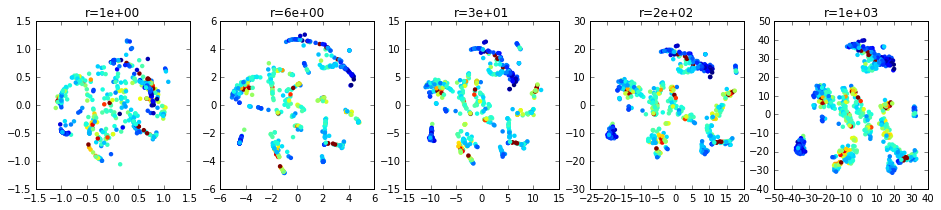

In [28]:
# importance of learning rate with random initialization
X,color = utils.get_data(2)
Y0 = np.random.multivariate_normal([0.0,0.0], 10e-4*np.eye(2), len(X))

n = 5
plt.figure(figsize=(16,int(16/n)))
for i,r in enumerate(np.logspace(0,3,n)):
#     print("\nr = %.e" % (r))
    Y = TSNE(X,Y0,perplexity=30,learningrate=r,silent=True)
    plt.subplot(1,n,i+1)
    plt.scatter(*Y.T,c=color,linewidth=0)
    plt.title('r=%.e' %(r))
plt.show()

Loading iris


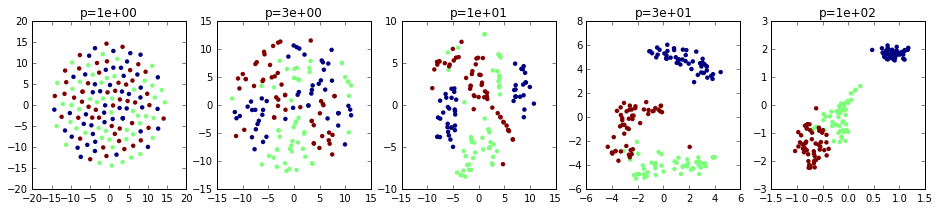

In [29]:
X,color = utils.get_data(3)
Y0 = np.random.multivariate_normal([0.0,0.0], 10e-4*np.eye(2), len(X))

n = 5
plt.figure(figsize=(16,int(16/n)))
for i,p in enumerate(np.logspace(0,2,n)):
#     print("\np = %.e" % (p))
    Y = TSNE(X,Y0,perplexity=p,learningrate=5.0,silent=True)
    plt.subplot(1,n,i+1)
    plt.scatter(*Y.T,c=color,linewidth=0)
    plt.title('p=%.e' %(p))
plt.show()

Loading iris

p = 30


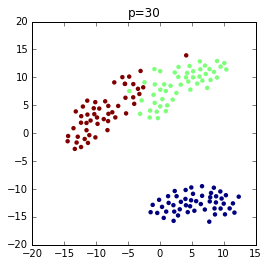


p = 35


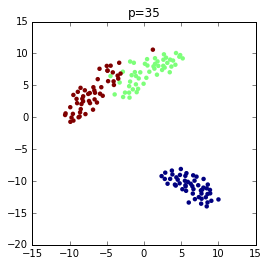


p = 40


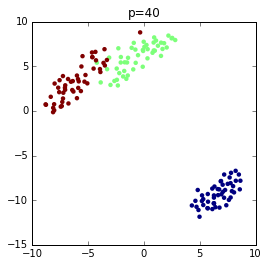


p = 45


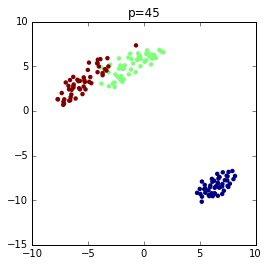


p = 50


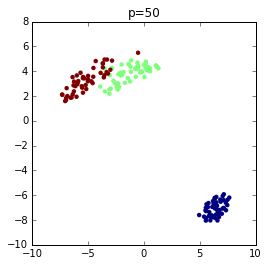


p = 55


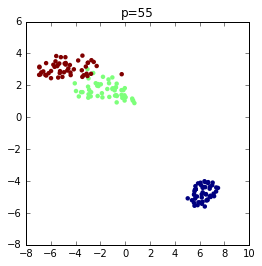


p = 60


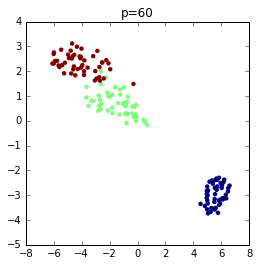


p = 65


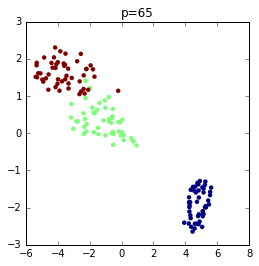


p = 70


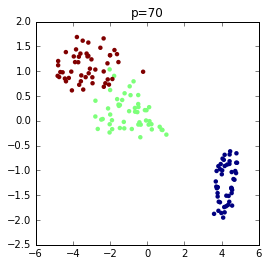


p = 75


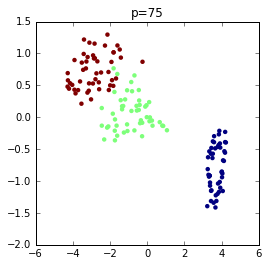


p = 80


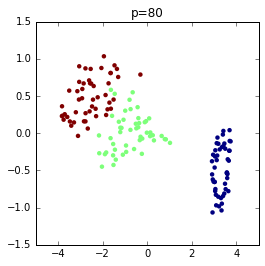


p = 85


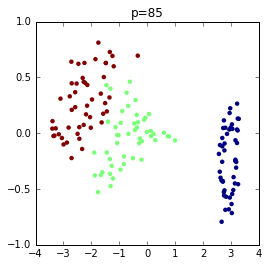

In [16]:
X,color = utils.get_data(3)
Y0 = np.random.multivariate_normal([0.0,0.0], 10e-4*np.eye(2), len(X))

n = 5
for p in range(30,90,5):
    print("\np = " + str(p))
    plt.figure(figsize=(4,4))
    Y = TSNE(X,Y0,perplexity=p,learningrate=100,silent=True)
#     plt.subplot(1,n,i+1)
    plt.scatter(*Y.T,c=color,linewidth=0)
    plt.title('p=' + str(p))
    plt.show()

Loading iris


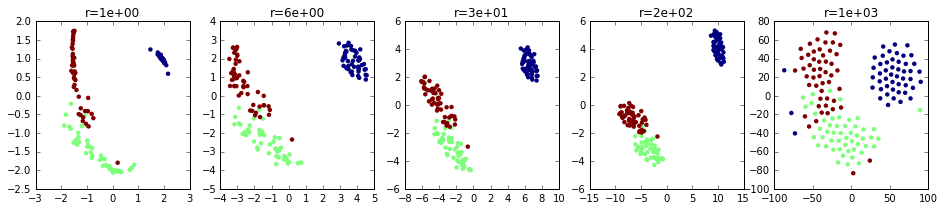

In [30]:
# importance of learning rate with random initialization
X,color = utils.get_data(3)
Y0 = np.random.multivariate_normal([0.0,0.0], 10e-4*np.eye(2), len(X))

n = 5
plt.figure(figsize=(16,int(16/n)))
for i,r in enumerate(np.logspace(0,3,n)):
#     print("\nr = %.e" % (r))
    Y = TSNE(X,Y0,perplexity=50,learningrate=r,silent=True)
    plt.subplot(1,n,i+1)
    plt.scatter(*Y.T,c=color,linewidth=0)
    plt.title('r=%.e' %(r))
plt.show()